In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from sklearn.preprocessing import QuantileTransformer

import warnings
warnings.filterwarnings("ignore")

%matplotlib widget

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_misc, utils_io, utils_plotting, utils_manifold, utils_atlas
from lib_data import DATA_IO

In [2]:
# get the ventral and dorsal borders of sensorymotor STN in z axis
STN_meshes            = utils_atlas.load_STN_meshes()
STN_SM_mesh           = STN_meshes["right"]["stn_SM"]
z_min                 = STN_SM_mesh.GetBounds()[4]
z_max                 = STN_SM_mesh.GetBounds()[5]
z_threshold           = (z_max + z_min) / 2 # threshold for dorsal vs ventral LFP channels

# load the data
LFP_PSD_controlateral = utils_io.load_LFP_event_PSD(event_category="tapping", event_laterality="controlateral")
LFP_PSD               = pd.DataFrame()

for severity in LFP_PSD_controlateral.keys():
    LFP_PSD = pd.concat([LFP_PSD, LFP_PSD_controlateral[severity]], ignore_index=True)

## LID severity 3: noLID_noDOPA, noLID_DOPA, LID
LFP_PSD["LID"]                                                                      = LFP_PSD.dyskinesia_arm.copy()
LFP_PSD.loc[(LFP_PSD['LID']!= "none"), "LID"]                                       = 'LID'
LFP_PSD.loc[(LFP_PSD['LID']== "none")& (LFP_PSD['event_start_time'] <= 30 ), "LID"] = 'noLID_noDOPA'
LFP_PSD.loc[(LFP_PSD['LID']== "none")& (LFP_PSD['event_start_time'] > 30 ) , "LID"] = 'noLID_DOPA'

LFP_PSD["hemisphere"]  = LFP_PSD["LFP_hemisphere"]
LFP_PSD["channel"]     = LFP_PSD["LFP_channel"]

features_pre_event  = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean']
features_event      = ['event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean']
features_post_event = ['post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']
features            = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean',
                       'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean',
                       'post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']


# load LFP channels MNI coordinates
MNI_LFP_channels      = pd.read_pickle(DATA_IO.path_coordinates + "lfp_channel_stn_parcellation.pkl")
dataset               = pd.merge(LFP_PSD, MNI_LFP_channels[["patient","hemisphere","channel","x","y","z"]], on=['patient', 'hemisphere', 'channel'])
dataset_dorsal        = dataset[dataset.z <= z_threshold]
dataset_ventral       = dataset[dataset.z > z_threshold]

# represent each tapping activity as a single row by measuring the average activity across frequency bands across all channels
dataset_dorsal        = dataset_dorsal.groupby(['event_no', 'LID'])[features].mean().reset_index()
dataset_ventral       = dataset_ventral.groupby(['event_no', 'LID'])[features].mean().reset_index()

# 1. PCA Analysis

In [4]:
dataset_DOPA_OFF_vs_ON         = dataset[dataset.LID!="LID"]
dataset_DOPA_ON_vs_LID         = dataset[dataset.LID!="noLID_noDOPA"]
dataset_dorsal_DOPA_OFF_vs_ON  = dataset_dorsal[dataset_dorsal.LID!="LID"]
dataset_dorsal_DOPA_ON_vs_LID  = dataset_dorsal[dataset_dorsal.LID!="noLID_noDOPA"]
dataset_ventral_DOPA_OFF_vs_ON = dataset_ventral[dataset_ventral.LID!="LID"]
dataset_ventral_DOPA_ON_vs_LID = dataset_ventral[dataset_ventral.LID!="noLID_noDOPA"]

pca_DOPA_OFF_vs_ON             = utils_manifold.get_PCA_results(dataset_DOPA_OFF_vs_ON, "LID", features_pre_event, features_event, features_post_event)
pca_DOPA_ON_vs_LID             = utils_manifold.get_PCA_results(dataset_DOPA_ON_vs_LID, "LID", features_pre_event, features_event, features_post_event)
pca_dorsal_DOPA_OFF_vs_ON      = utils_manifold.get_PCA_results(dataset_dorsal_DOPA_OFF_vs_ON, "LID", features_pre_event, features_event, features_post_event)
pca_dorsal_DOPA_ON_vs_LID      = utils_manifold.get_PCA_results(dataset_dorsal_DOPA_ON_vs_LID, "LID", features_pre_event, features_event, features_post_event)
pca_ventral_DOPA_OFF_vs_ON     = utils_manifold.get_PCA_results(dataset_ventral_DOPA_OFF_vs_ON, "LID", features_pre_event, features_event, features_post_event)
pca_ventral_DOPA_ON_vs_LID     = utils_manifold.get_PCA_results(dataset_ventral_DOPA_ON_vs_LID, "LID", features_pre_event, features_event, features_post_event)

#dorsal_event_angles            = utils_manifold.angle_between_PCA_spaces(pca_dorsal_DOPA_OFF_vs_ON["event"]["components"], 
#                                                                         pca_dorsal_DOPA_ON_vs_LID["event"]["components"])
#ventral_event_angles           = utils_manifold.angle_between_PCA_spaces(pca_ventral_DOPA_OFF_vs_ON["event"]["components"], 
#                                                                         pca_ventral_DOPA_ON_vs_LID["event"]["components"])

In [42]:
pca_DOPA_ON_vs_LID['distances']

,segment,pc,p_value,cohens_d,p_value_corrected,sig
0,pre,pc1,3.124831e-04,0.107384,6.249663e-04,***
1,pre,pc2,4.833431e-03,0.087376,4.833431e-03,**
2,event,pc1,7.144535e-05,0.116309,7.144535e-05,***
3,event,pc2,8.759792e-58,0.499015,1.751958e-57,***
4,post,pc1,8.043661e-05,0.115380,8.043661e-05,***
5,post,pc2,5.421737e-24,0.305708,1.084347e-23,***


# 2 Plotting

## 2.1 Methods

In [38]:
colors                 = {}
colors["noLID_noDOPA"] = utils_plotting.colors["noLID_noDOPA"]
colors["noLID_DOPA"]   = utils_plotting.colors["noLID_DOPA"]
colors["LID"]          = utils_plotting.colors["LID"]

colors_frequency       = [utils_plotting.colors["theta"],
                          utils_plotting.colors["alpha"],
                          utils_plotting.colors["beta_low"],
                          utils_plotting.colors["beta_high"],
                          utils_plotting.colors["gamma"]]


def plot_PCA_projections(data, group_feature, colors, axis):

    groups = data[group_feature].unique()
    
    for group in groups:
        axis = sns.scatterplot(data=data[data[group_feature] == group], 
                               x="PC1", y="PC2", ax=axis, s=5, color=colors[group], rasterized=True)

        group_data = data[data[group_feature] == group]
        mean_x     = group_data["PC1"].mean()
        mean_y     = group_data["PC2"].mean()
        axis.hlines(y=mean_y, xmin=-5, xmax=-4, color=colors[group], linewidth=1.5)
        axis.vlines(x=mean_x, ymin=-5, ymax=-4, color=colors[group], linewidth=1.5)

    # remove spines
    axis.spines.left.set_visible(False)
    axis.spines.bottom.set_visible(False)
    axis.spines.right.set_visible(False)
    axis.spines.top.set_visible(False)
    axis.spines.left.set_visible(False)
    axis.spines.bottom.set_visible(False)
    axis.spines.right.set_visible(False)
    axis.spines.top.set_visible(False)

    # Remove the axes' borders (if still visible)
    axis.xaxis.set_ticks_position('none')  # Hide the x-axis ticks
    axis.yaxis.set_ticks_position('none')  # Hide the y-axis ticks

    return axis

def pca_projections(pre_data_pca, event_data_pca, post_data_pca, region, state):

    plt          = utils_plotting.get_figure_template()
    ax_pca_pre   = plt.subplot2grid((77, 66), (0, 0) , colspan=10, rowspan=10)
    ax_pca_event = plt.subplot2grid((77, 66), (0, 15) , colspan=10, rowspan=10)
    ax_pca_post  = plt.subplot2grid((77, 66), (0, 30) , colspan=10, rowspan=10)
    
    ax_pca_pre   = plot_PCA_projections(pre_data_pca, group_feature="severity", colors=colors, axis=ax_pca_pre)
    ax_pca_event = plot_PCA_projections(event_data_pca, group_feature="severity", colors=colors, axis=ax_pca_event)
    ax_pca_post  = plot_PCA_projections(post_data_pca, group_feature="severity", colors=colors, axis=ax_pca_post)
    
    ax_pca_pre.set_xlim([-5,5])
    ax_pca_event.set_xlim([-5,5])
    ax_pca_post.set_xlim([-5,5])
    
    ax_pca_pre.set_ylim([-5,5])
    ax_pca_event.set_ylim([-5,5])
    ax_pca_post.set_ylim([-5,5])
    
    ax_pca_pre.set_xticklabels(ax_pca_pre.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_pre.set_yticklabels(ax_pca_pre.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_event.set_xticklabels(ax_pca_event.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_event.set_yticklabels(ax_pca_event.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_post.set_xticklabels(ax_pca_post.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_post.set_yticklabels(ax_pca_post.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)
    ax_pca_event.set_title(f"{region} STN - {state}", fontsize=utils_plotting.LABEL_SIZE)
    plt.tight_layout()
    plt.savefig(DATA_IO.path_figure + f'pca/projections/stn_{region}_{state}.svg', dpi=300)

def plot_loadings(df_pca_contributions, region, state):
    plt    = utils_plotting.get_figure_template()
    
    ax_PC1 = plt.subplot2grid((77, 66), (0, 0), colspan=10, rowspan=6)
    ax_PC2 = plt.subplot2grid((77, 66), (10, 0), colspan=10, rowspan=6)
    
    ax_PC1 = sns.lineplot(data=df_pca_contributions, x="segment", y="PC1", hue="band", markers=True, palette=colors_frequency, 
                          marker="o", ax=ax_PC1, linewidth=0.6, markersize=5, legend=False)
    ax_PC2 = sns.lineplot(data=df_pca_contributions, x="segment", y="PC2", hue="band", markers=True, palette=colors_frequency,
                          marker="o", ax=ax_PC2, linewidth=0.6, markersize=5, legend=False)

    ax_PC1.set_title(f"{region} STN - {state}", fontsize=utils_plotting.LABEL_SIZE)
    
    ax_PC1.set_yticks([0, 0.25, 0.50, 0.75, 1])
    ax_PC2.set_yticks([0, 0.25, 0.50, 0.75, 1])
    utils_plotting.set_axis(ax_PC1)
    utils_plotting.set_axis(ax_PC2)
    plt.tight_layout()
    plt.savefig(DATA_IO.path_figure + f'pca/loadings/stn_{region}_{state}.svg', dpi=300)

def plot_cohens_d(df, axis):

    def significance_stars(p):
        if(p <= 0.001)  : return "***"
        elif(p <= 0.01) : return "**"
        elif(p <= 0.05) : return "*"
        else            : return ""
    
    df["sig"] = df["p_value_corrected"].apply(significance_stars)
    
    # Create the bar plot
    sns.barplot(data=df, x="segment", y="cohens_d", hue="pc", ax=axis, palette="Set2", capsize=0.1, width=0.7, legend=False)

    # Add significance stars above each bar
    for i, row in df.iterrows():
        bar_height = row["cohens_d"]
        axis.text(x=i // df["pc"].nunique() + (i % df["pc"].nunique())*0.2 - 0.1, y=bar_height + 0.02, s=row["sig"], 
                  ha='center', va='bottom', fontsize=utils_plotting.LABEL_SIZE)

    # Add horizontal lines for Cohen's d effect size interpretation
    effect_sizes = [0.2, 0.5, 0.8]
    for es in effect_sizes:
        axis.axhline(es, color='lightgrey', linestyle='-', linewidth=0.5)

    axis.set_ylabel("Cohen's d")
    axis.set_xlabel("Segment")
    axis.set_ylim([0,1])

def plot_explained_variance(pre_explained_variance, event_explained_variance, post_explained_variance, region, state):
    
    plt    = utils_plotting.get_figure_template()
    
    ax_PC1 = plt.subplot2grid((77, 66), (0, 0), colspan=13, rowspan=3)
    ax_PC2 = plt.subplot2grid((77, 66), (10, 0), colspan=13, rowspan=3)
    ax_PC3 = plt.subplot2grid((77, 66), (20, 0), colspan=13, rowspan=3)
    
    ax_PC1 = sns.barplot(data=pre_explained_variance, x="score", y="component", ax=ax_PC1)
    ax_PC2 = sns.barplot(data=event_explained_variance, x="score", y="component", ax=ax_PC2)
    ax_PC3 = sns.barplot(data=post_explained_variance, x="score", y="component", ax=ax_PC3)
    
    utils_plotting.set_axis(ax_PC1)
    utils_plotting.set_axis(ax_PC2)
    utils_plotting.set_axis(ax_PC3)
    
    ax_PC1.set_xticks([0, 0.25,0.5])
    ax_PC2.set_xticks([0, 0.25,0.5])
    ax_PC3.set_xticks([0, 0.25,0.5])
    
    ax_PC1.set_xlim([0,0.5])
    ax_PC2.set_xlim([0,0.5])
    ax_PC3.set_xlim([0,0.5])

    ax_PC1.set_title(f"{region} STN - {state}", fontsize=utils_plotting.LABEL_SIZE)
    plt.savefig(DATA_IO.path_figure + f'pca/explained_variances/stn_{region}_{state}.svg', dpi=300)

## 2.2 PCA Projections 

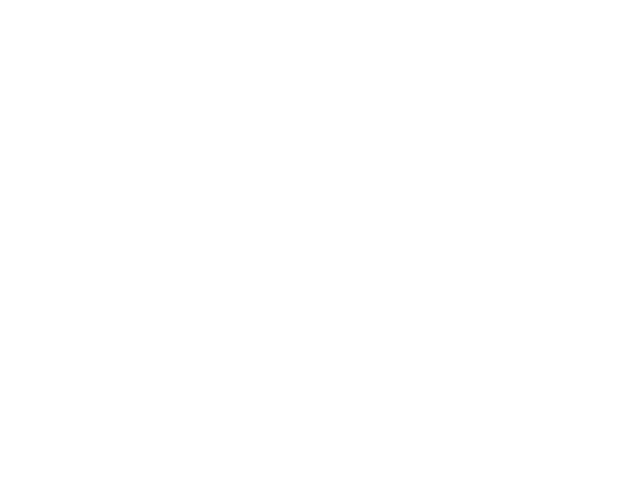

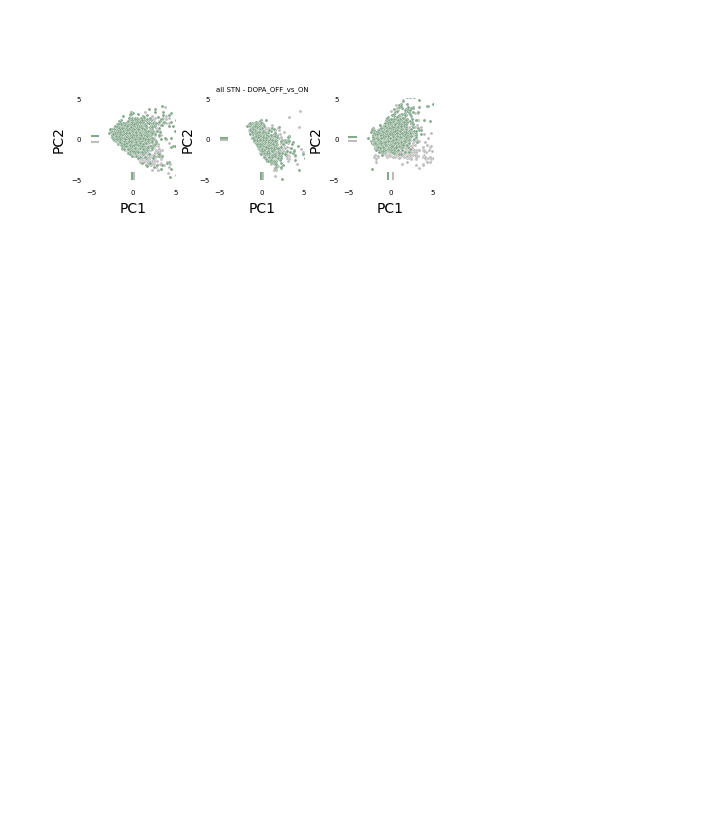

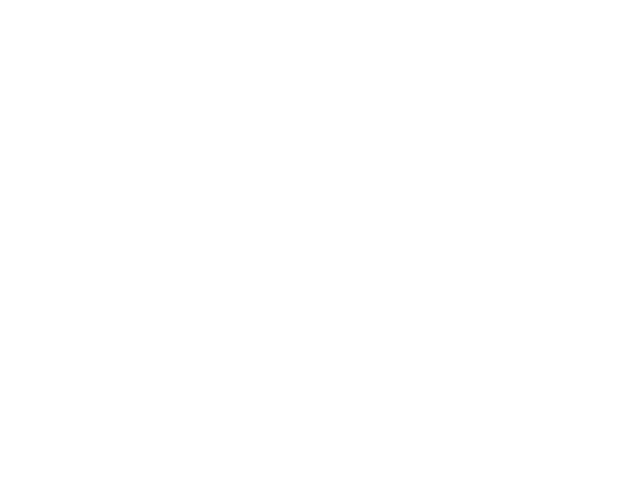

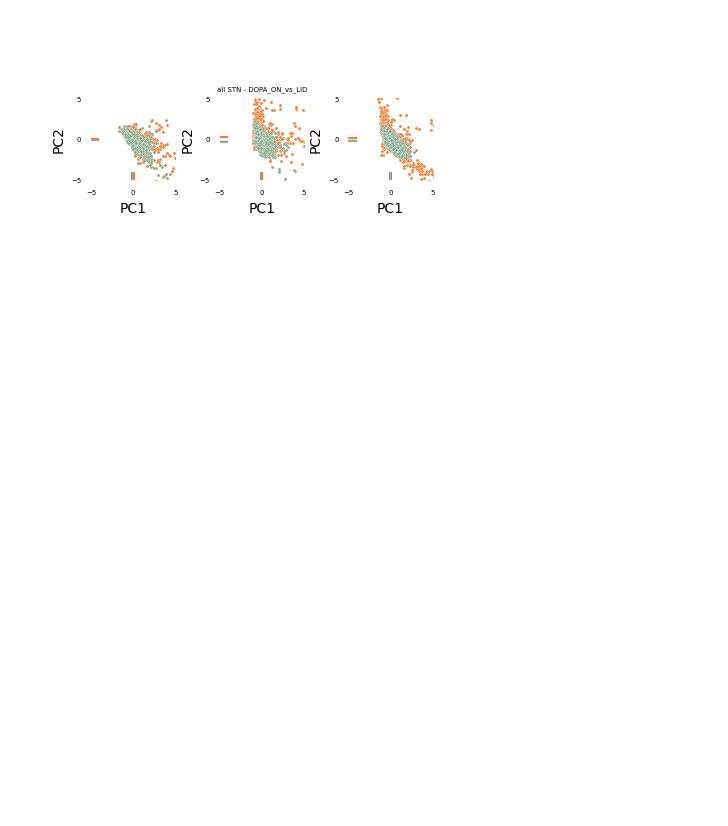

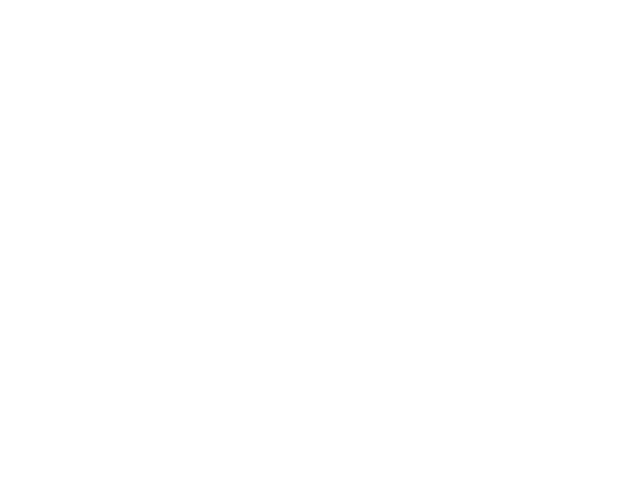

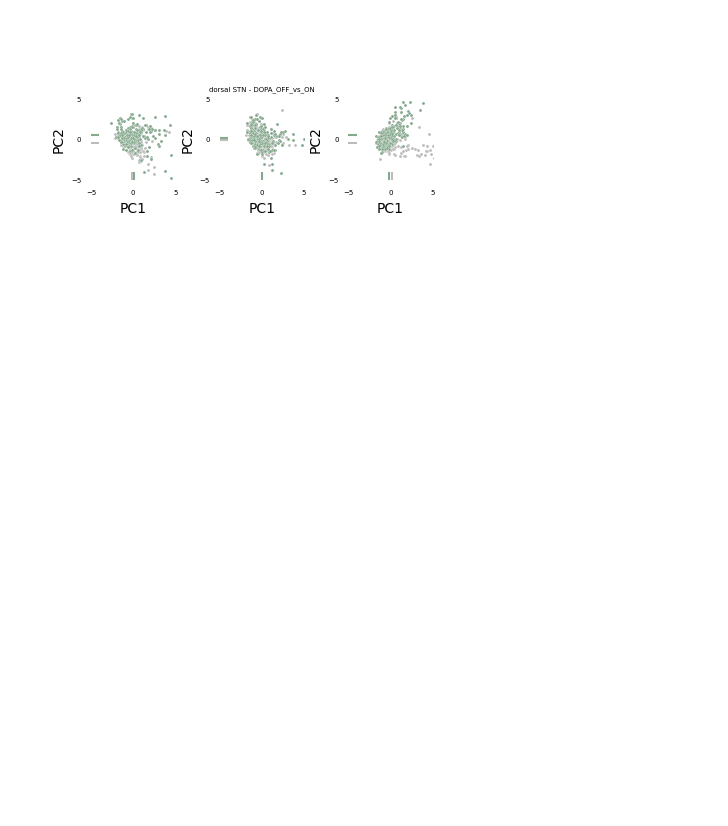

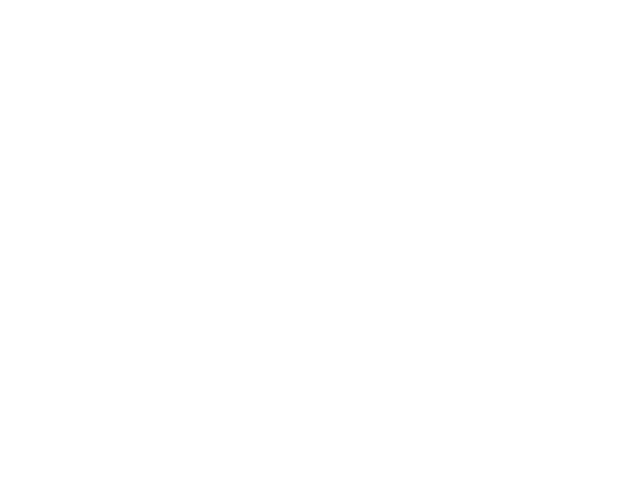

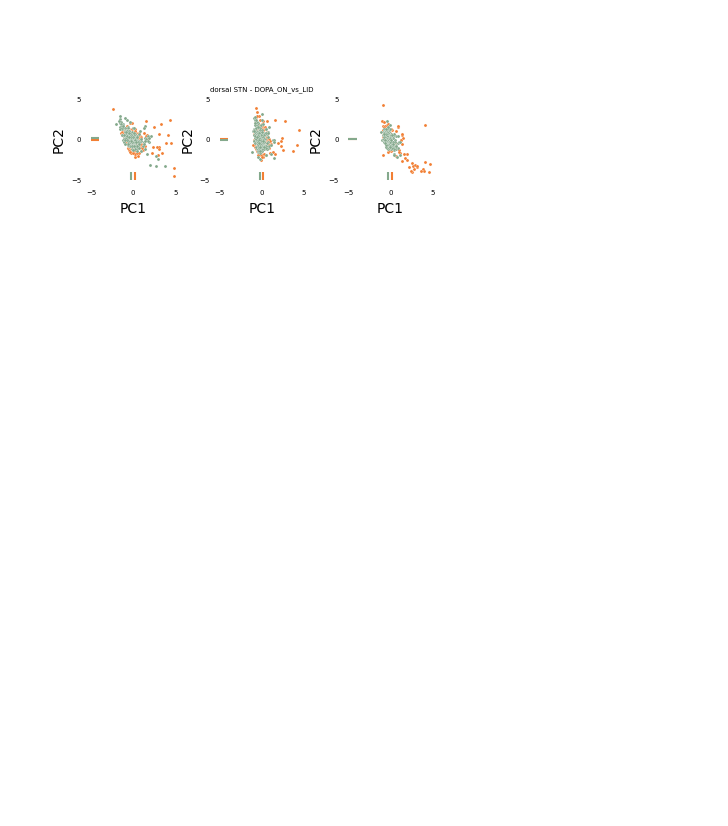

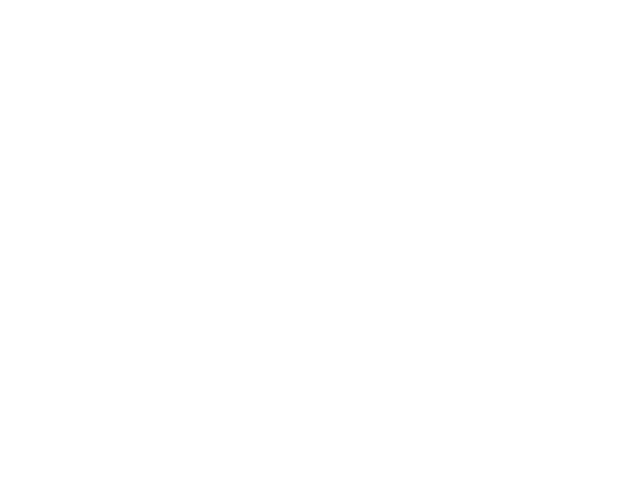

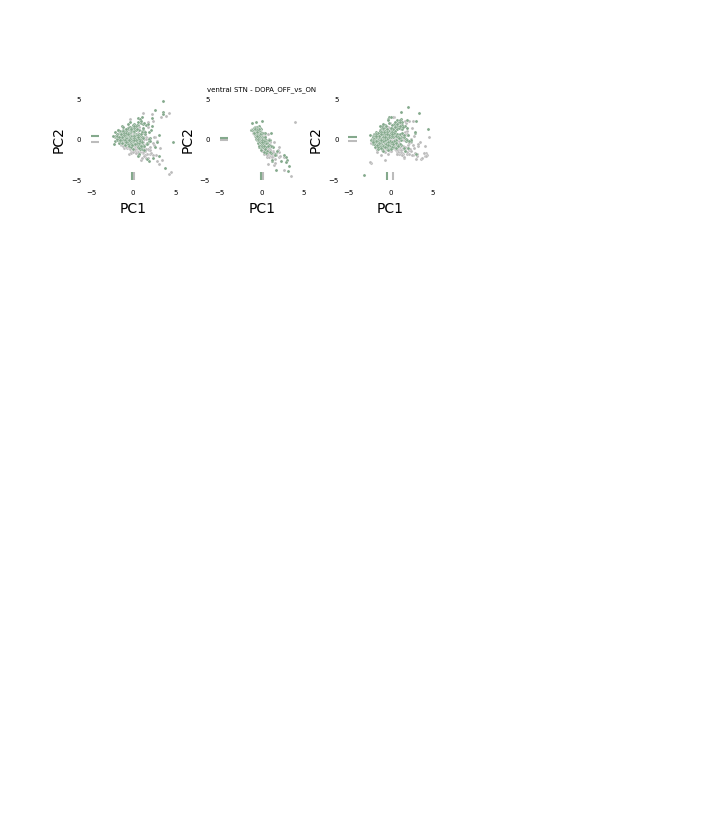

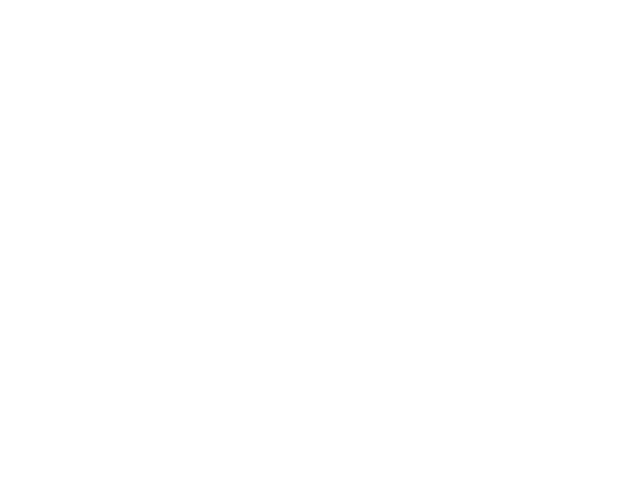

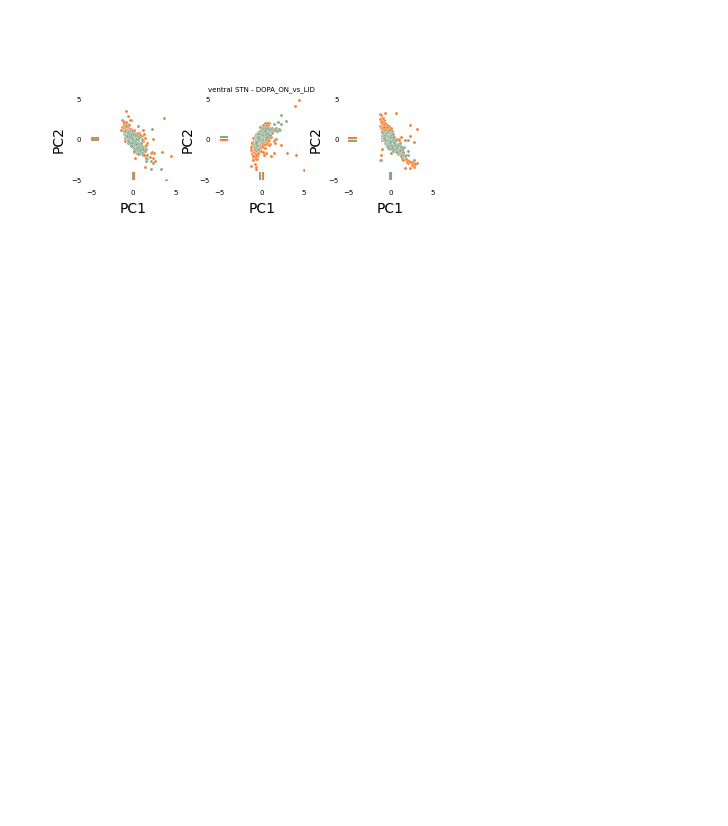

In [13]:
pca_projections(pca_DOPA_OFF_vs_ON["pre"]['pca'], 
                pca_DOPA_OFF_vs_ON["event"]['pca'], 
                pca_DOPA_OFF_vs_ON["post"]['pca'], region="all" , state="DOPA_OFF_vs_ON")
pca_projections(pca_DOPA_ON_vs_LID["pre"]['pca'], 
                pca_DOPA_ON_vs_LID["event"]['pca'], 
                pca_DOPA_ON_vs_LID["post"]['pca'], region="all" , state="DOPA_ON_vs_LID")

pca_projections(pca_dorsal_DOPA_OFF_vs_ON["pre"]['pca'], 
                pca_dorsal_DOPA_OFF_vs_ON["event"]['pca'], 
                pca_dorsal_DOPA_OFF_vs_ON["post"]['pca'], region="dorsal" , state="DOPA_OFF_vs_ON")
pca_projections(pca_dorsal_DOPA_ON_vs_LID["pre"]['pca'], 
                pca_dorsal_DOPA_ON_vs_LID["event"]['pca'], 
                pca_dorsal_DOPA_ON_vs_LID["post"]['pca'], region="dorsal" , state="DOPA_ON_vs_LID")

pca_projections(pca_ventral_DOPA_OFF_vs_ON["pre"]['pca'], 
                pca_ventral_DOPA_OFF_vs_ON["event"]['pca'], 
                pca_ventral_DOPA_OFF_vs_ON["post"]['pca'], region="ventral" , state="DOPA_OFF_vs_ON")
pca_projections(pca_ventral_DOPA_ON_vs_LID["pre"]['pca'], 
                pca_ventral_DOPA_ON_vs_LID["event"]['pca'], 
                pca_ventral_DOPA_ON_vs_LID["post"]['pca'], region="ventral" , state="DOPA_ON_vs_LID")

## 2.3 PCA Loadings

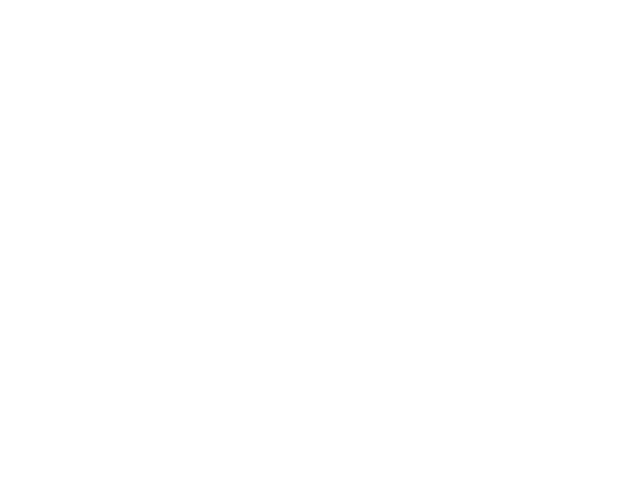

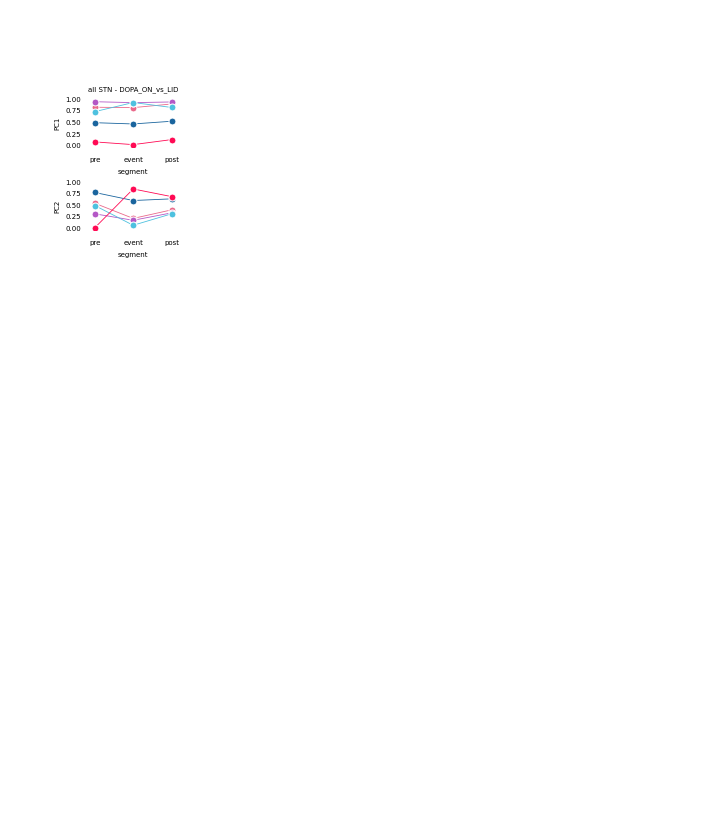

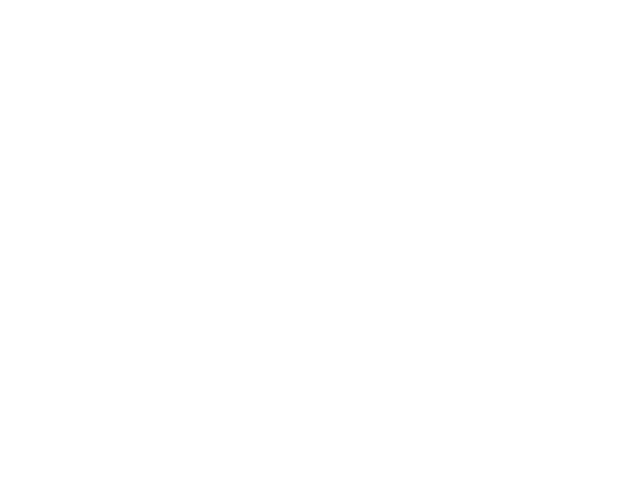

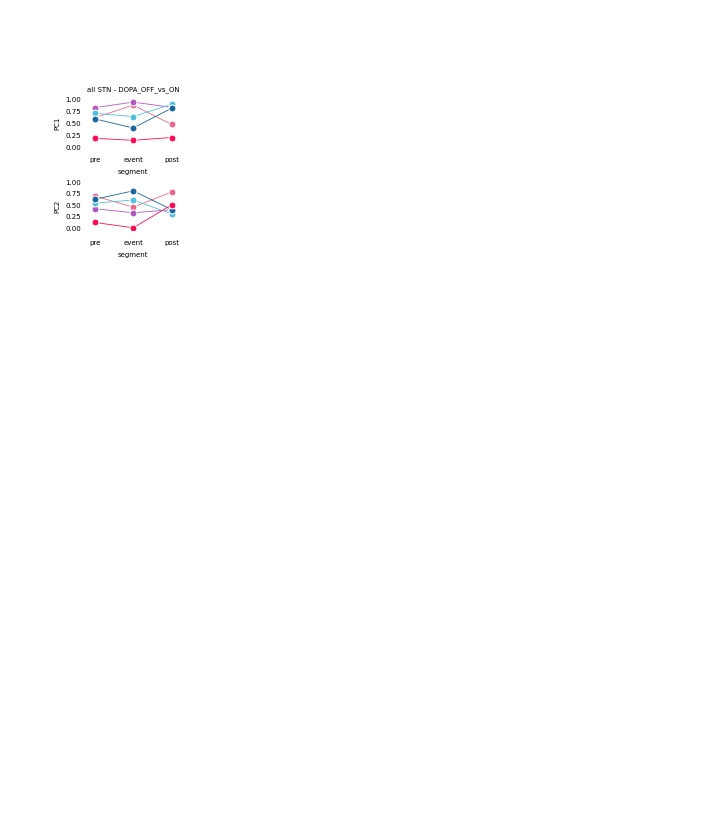

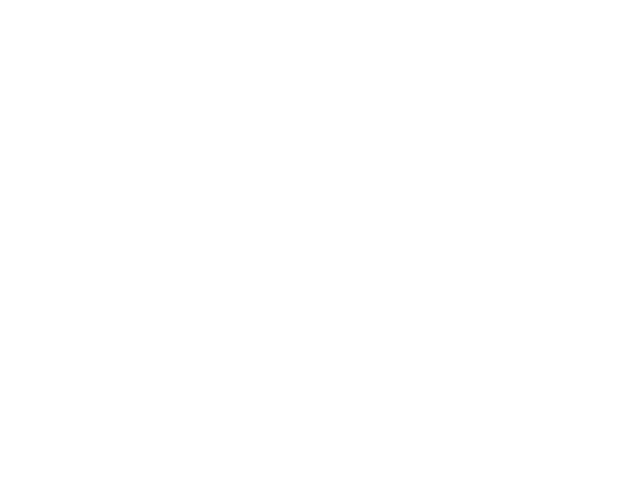

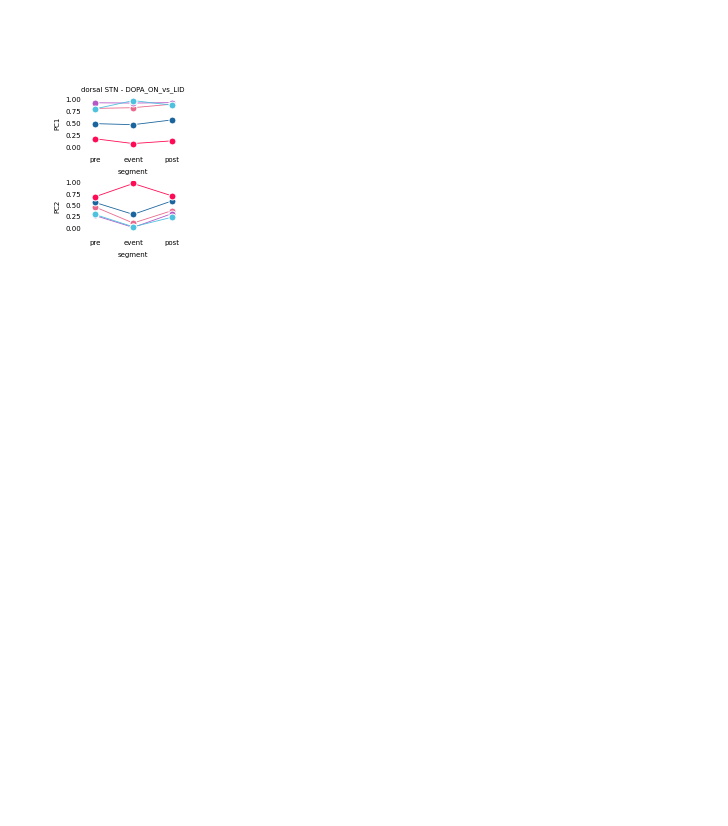

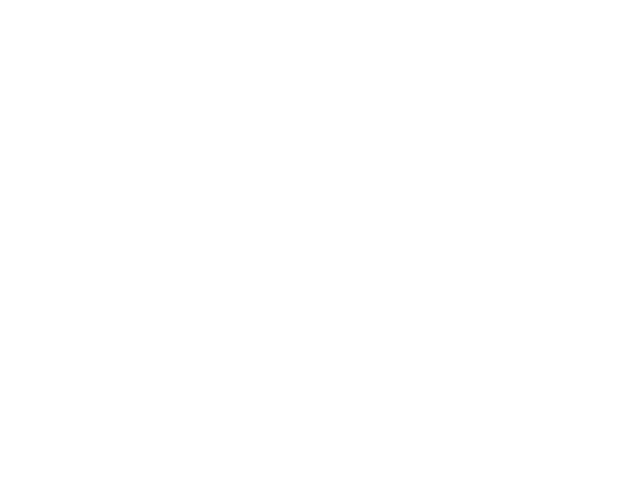

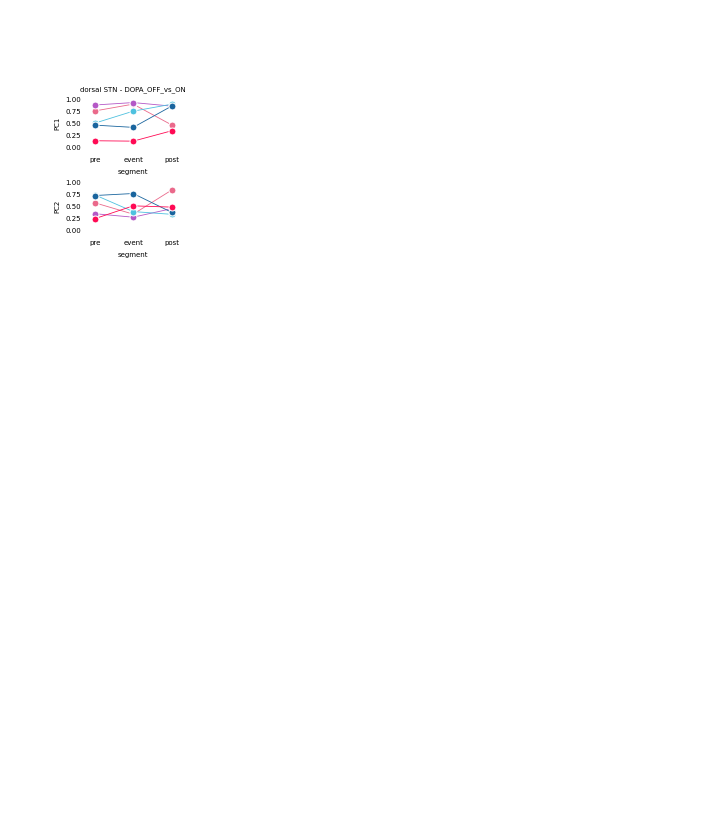

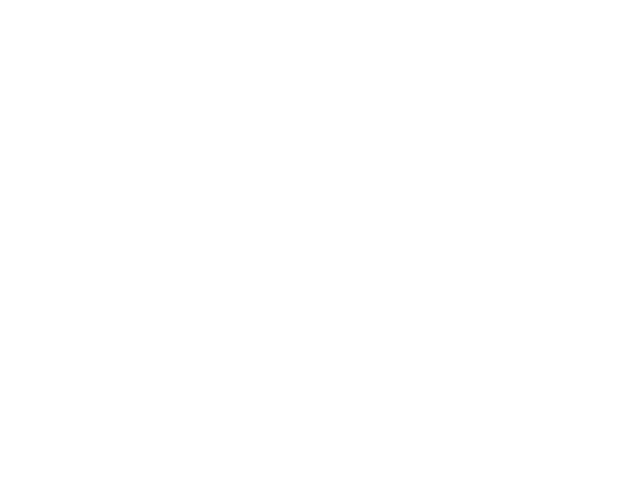

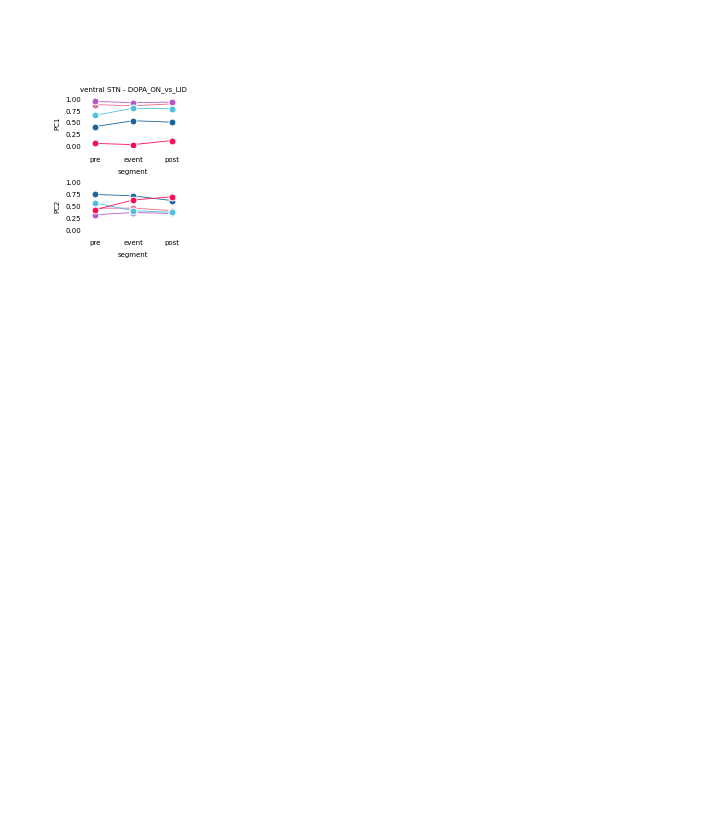

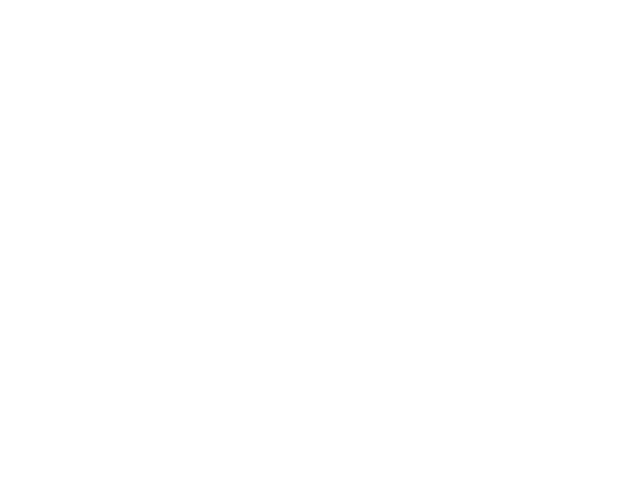

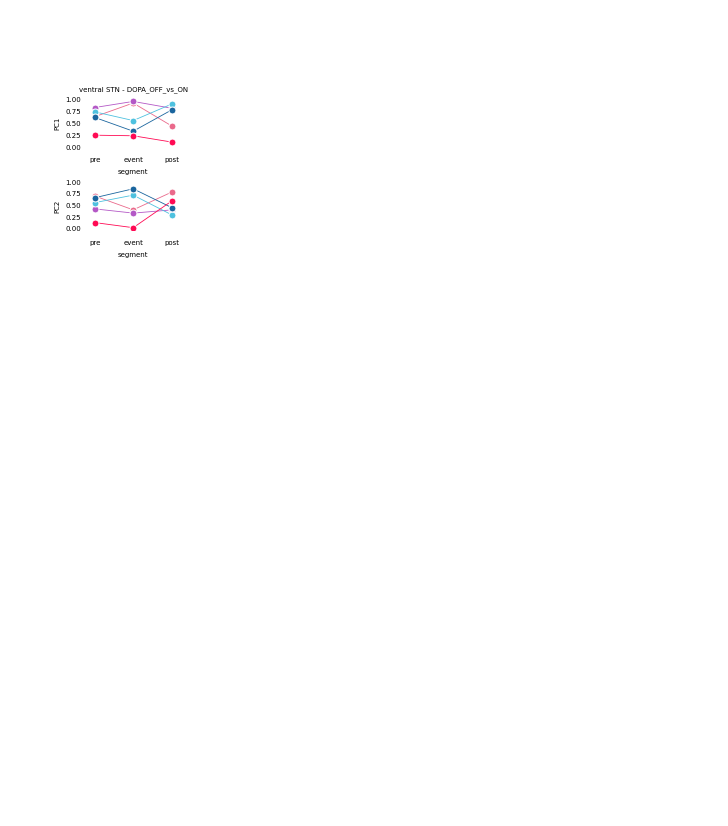

In [15]:
plot_loadings(pca_DOPA_ON_vs_LID['loadings'], region="all", state="DOPA_ON_vs_LID")
plot_loadings(pca_DOPA_OFF_vs_ON['loadings'], region="all", state="DOPA_OFF_vs_ON")
plot_loadings(pca_dorsal_DOPA_ON_vs_LID['loadings'], region="dorsal", state="DOPA_ON_vs_LID")
plot_loadings(pca_dorsal_DOPA_OFF_vs_ON['loadings'], region="dorsal", state="DOPA_OFF_vs_ON")
plot_loadings(pca_ventral_DOPA_ON_vs_LID['loadings'], region="ventral", state="DOPA_ON_vs_LID")
plot_loadings(pca_ventral_DOPA_OFF_vs_ON['loadings'], region="ventral", state="DOPA_OFF_vs_ON")

## 2.4 Plot Distances

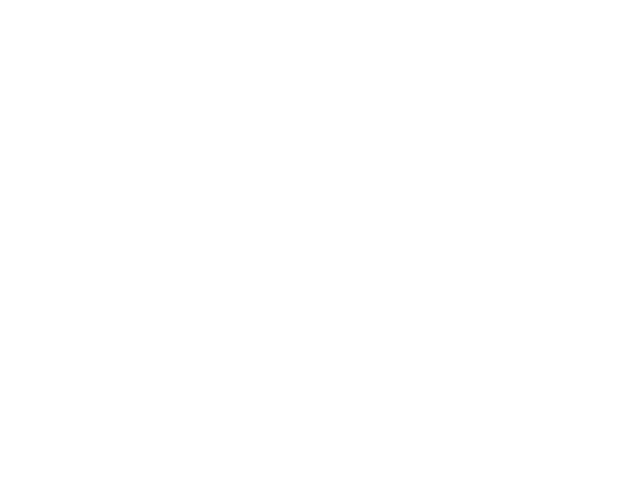

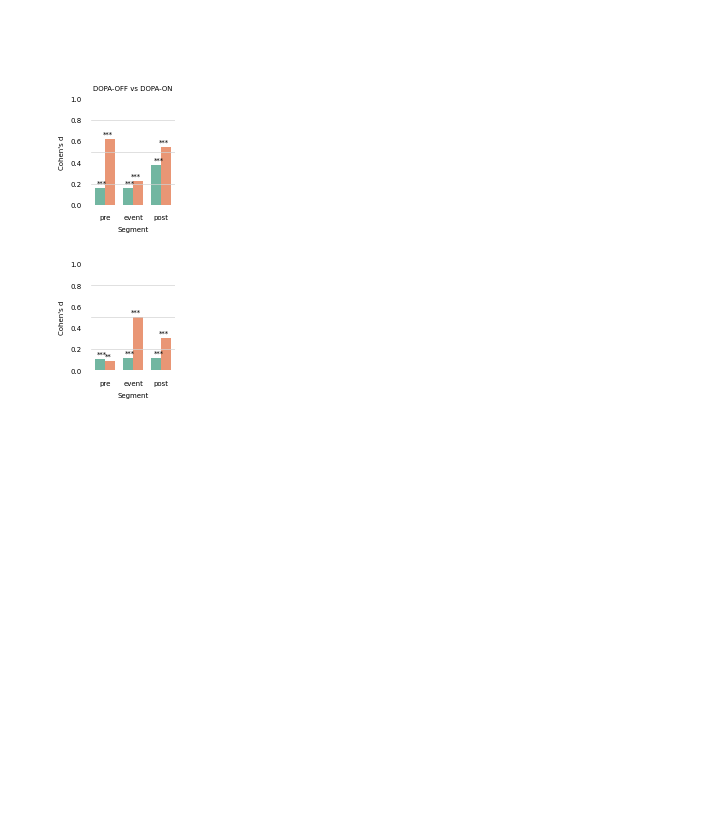

In [20]:
plt       = utils_plotting.get_figure_template()
ax_off_on = plt.subplot2grid((77, 66), (0, 0) , colspan=10, rowspan=13)
ax_on_lid = plt.subplot2grid((77, 66), (20, 0), colspan=10, rowspan=13)
plot_cohens_d(pca_DOPA_OFF_vs_ON['distances'], axis=ax_off_on)
plot_cohens_d(pca_DOPA_ON_vs_LID['distances'], axis=ax_on_lid)
utils_plotting.set_axis(ax_off_on)
utils_plotting.set_axis(ax_on_lid)
ax_off_on.set_title("DOPA-OFF vs DOPA-ON", fontsize=utils_plotting.LABEL_SIZE)
ax_off_on.set_title("DOPA-OFF vs DOPA-ON", fontsize=utils_plotting.LABEL_SIZE)
plt.savefig(DATA_IO.path_figure + f'pca/distances_stn_all.svg', dpi=300)

## 2.5 Plot Explained Variance

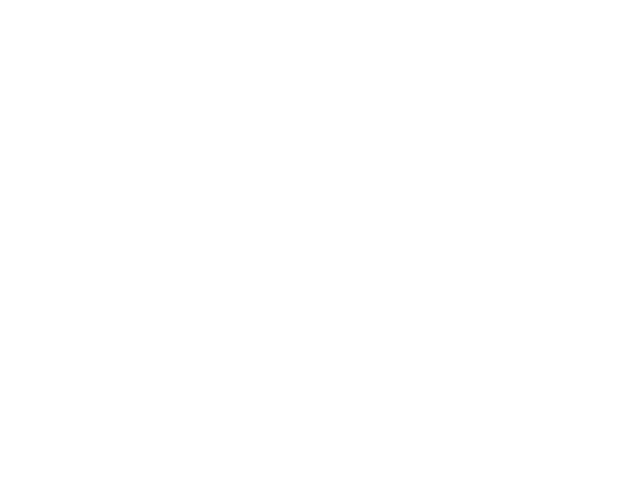

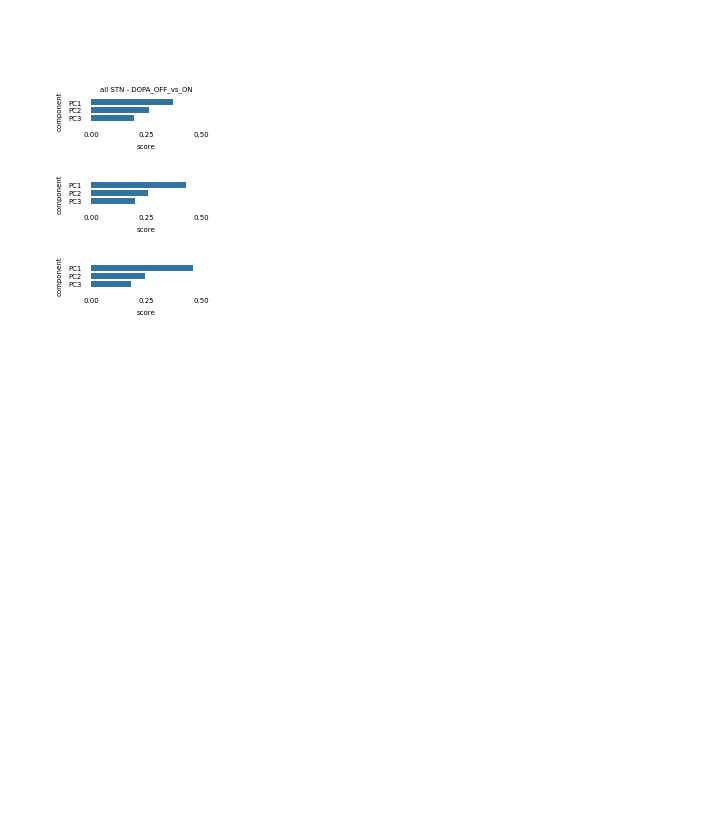

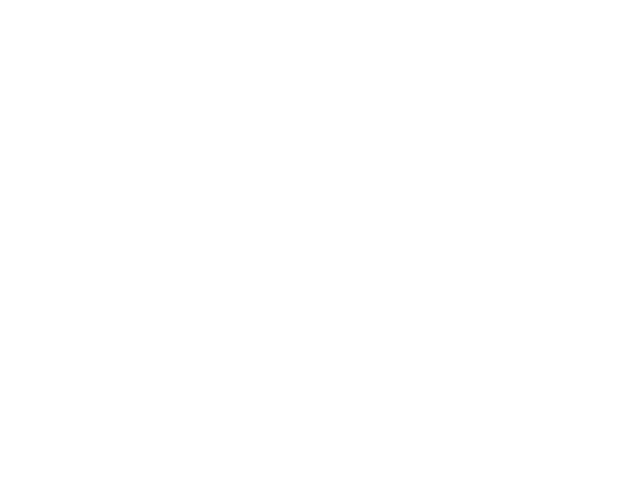

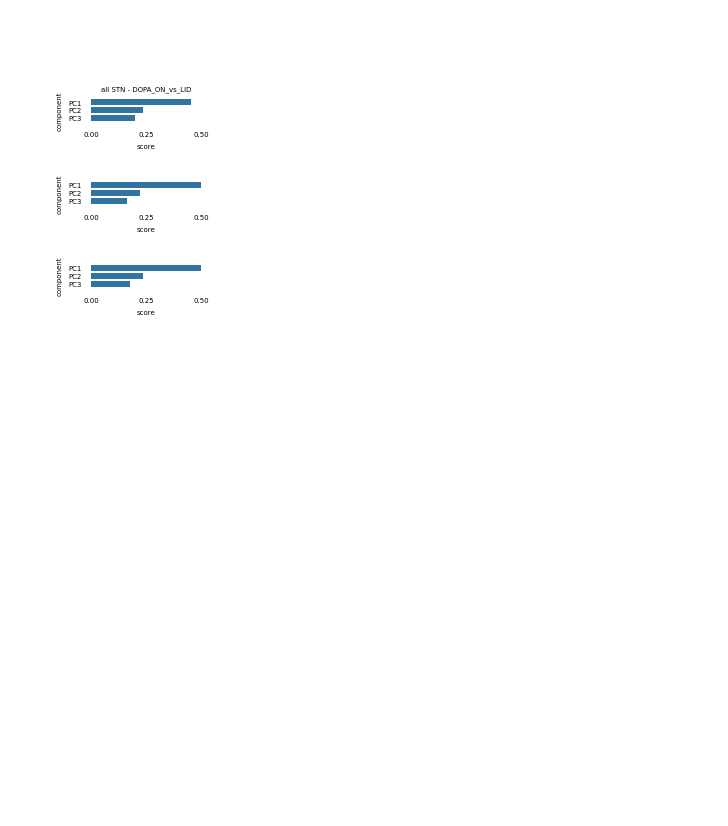

In [40]:
plot_explained_variance(pca_DOPA_OFF_vs_ON['pre']['ev'], pca_DOPA_OFF_vs_ON['event']['ev'], pca_DOPA_OFF_vs_ON['post']['ev'], region="all", state="DOPA_OFF_vs_ON")
plot_explained_variance(pca_DOPA_ON_vs_LID['pre']['ev'], pca_DOPA_ON_vs_LID['event']['ev'], pca_DOPA_ON_vs_LID['post']['ev'], region="all", state="DOPA_ON_vs_LID")

## 2.6 CH Scores

In [ ]:
severity_mapping  = {'noLID_noDOPA':0, 'noLID_DOPA':1, 'LID':2}
ch_pre_event      = utils_statistics.ch_score(pre_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_event          = utils_statistics.ch_score(event_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_post_event     = utils_statistics.ch_score(post_data_pca[["PC1","severity"]], group_label="severity", group_mapping=severity_mapping)

plt      = utils_plotting.get_figure_template()

ax_pre   = plt.subplot2grid((77, 66), (0, 0), colspan=5, rowspan=5)
ax_event = plt.subplot2grid((77, 66), (0, 15), colspan=5, rowspan=5)
ax_post  = plt.subplot2grid((77, 66), (0, 30), colspan=5, rowspan=5)

ax_pre   = sns.heatmap(ch_pre_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_pre, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_event = sns.heatmap(ch_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_event, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_post  = sns.heatmap(ch_post_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_post, cbar=False, annot=False, annot_kws={"fontsize":5})

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + 'pca/stn_PC1_ch.svg', dpi=300)

In [ ]:
severity_mapping  = {'noLID_noDOPA':0, 'noLID_DOPA':1, 'LID':2}
ch_pre_event      = utils_statistics.ch_score(pre_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_event          = utils_statistics.ch_score(event_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)
ch_post_event     = utils_statistics.ch_score(post_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)

plt      = utils_plotting.get_figure_template()

ax_pre   = plt.subplot2grid((77, 66), (0, 0), colspan=5, rowspan=5)
ax_event = plt.subplot2grid((77, 66), (0, 15), colspan=5, rowspan=5)
ax_post  = plt.subplot2grid((77, 66), (0, 30), colspan=5, rowspan=5)

ax_pre   = sns.heatmap(ch_pre_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_pre, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_event = sns.heatmap(ch_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_event, cbar=False, annot=False, annot_kws={"fontsize":5})
ax_post  = sns.heatmap(ch_post_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_post, cbar=False, annot=False, annot_kws={"fontsize":5})

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + 'pca/stn_PC2_ch.svg', dpi=300)

In [ ]:
severity_mapping  = {'noLID_noDOPA':0, 'noLID_DOPA':1, 'LID':2}
ch_pre_event      = utils_statistics.ch_score(pre_data_pca[["PC2","severity"]], group_label="severity", group_mapping=severity_mapping)

plt      = utils_plotting.get_figure_template()
ax_pre   = plt.subplot2grid((77, 66), (0, 0), colspan=5, rowspan=15)
ax_pre   = sns.heatmap(ch_pre_event, vmin=0, vmax=200, cmap="RdPu", ax=ax_pre, cbar=True, annot=False, annot_kws={"fontsize":5})

utils_plotting.set_axis(ax_pre)

plt.savefig(DATA_IO.path_figure + 'pca/stn_ch_cbar.svg', dpi=300)